### Outline
1. Why vectorization
2. Vectorisation examples
3. Scalar class -recap
4. Class with vectorised weights (first convert weights of scalar class to vector)
5. Class with vectorised weights and inputs (then convert inputs of scalar class to vector too)
6. Exercise

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook
import seaborn as sns
import imageio
from IPython.display import HTML

from sklearn.preprocessing import  OneHotEncoder
from sklearn.datasets import make_blobs

my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["red","yellow","green"])
np.random.seed(0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Generate Data

In [2]:
data, labels = make_blobs(n_samples = 1000, centers = 4, n_features = 2, random_state=0)

print(data.shape, labels.shape)

(1000, 2) (1000,)


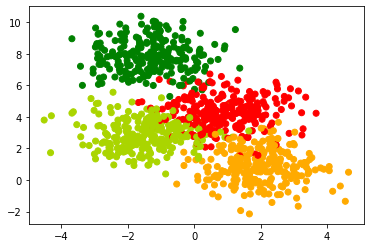

In [3]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap = my_cmap)
plt.show()

# Multi class Classification

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify = labels, random_state = 0)

In [6]:
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


Again 2 neurons in first hidden layer and 4 neurons in output layer.

In [8]:
# W1 : 4 weights coming to first layer, 8 weights coming to second layer
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)
print(W1, W2)

[[ 1.49407907 -0.20515826]
 [ 0.3130677  -0.85409574]] [[-2.55298982  0.6536186   0.8644362  -0.74216502]
 [ 2.26975462 -1.45436567  0.04575852 -0.18718385]]


# Weight Vectorised Version

In [0]:
class FF_MultiClass_WeightVectorised:

  def __init__(self):

    # Deep copy
    self.W1 = W1.copy()
    self.W2 = W2.copy()

    # B2 contains biases for each neuron of second layer in one variable!
    self.B1 = np.zeros((1,2))
    self.B2 = np.zeros((1,4))

  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))

  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)

  # much shorter in vectorised version
  def forward_pass(self, x):
    # Convert to row
    # When playing with vectors i.e. tensors, always keep record of dimensions! Else for higher dimensions, we'll be choosing the wrong matrices to be multiplied

    x = x.reshape(1, -1) # (1, 2) for a single x (record)

    # np.multiply does point-wise multiplication while matmul does row*col (the normal multiplication)
    self.A1 = np.matmul(x, self.W1)+self.B1 # (1,2) * (2,2) = (1,2)
    
    # np.exp getting broadcasted to all elements, thus same vector size returned
    self.H1 = self.sigmoid(self.A1) # (1,2)
    self.A2 = np.matmul(self.H1, self.W2) + self.B2 # (1,2) * (2,4) = (1,4)
    
    # Like np.exp, since we have defined sigmoid function, we have used np.sum and np.exp which can support vectorization by performing operation individually on each of them
    self.H2 = self.sigmoid(self.A2) # (1,4)
    return self.H2

  # grad (partial derivative) of sigmoid function
  def grad_sigmoid(self, x):
    return x*(1-x)

  def grad(self, x, y):
    self.forward_pass(x)
    x = x.reshape(1, -1) # (1, 2)
    y = y.reshape(1, -1) # (1, 4)

    # Basically going backwards using the estimated prameters (estimated during forward pass)
    self.dA2 = self.H2 - y # -(y-y') # (1, 4)
    
    self.dW2 = np.matmul(self.H1.T , self.dA2) # (2,1) * (1,4) = (2,4)
    self.dB2 = self.dA2 # (1,4)

    self.dH1 = np.matmul(self.dA2, self.W2.T) # (1, 4) * (4, 2) = (1,2)
    # Pointwise mulitplication! 
    self.dA1 = np.multiply(self.dH1, self.grad_sigmoid(self.H1)) # (1,2) * (1,2) = (1,2)

    self.dW1 = np.matmul(x.T, self.W2.T) # (2,1) * (1,2) = (2,2)
    self.dB1 = self.dA1 # (1,2)

    # Note all derivatives have the same dimensions as their original ones

  def fit(self, X, Y, epochs = 1, learning_rate = 1, display_loss = False):
    if display_loss:
      loss = {}

    for i in tqdm_notebook(range(epochs), total = epochs, unit="epoch"):
      dW1 = np.zeros((2,2))
      dW2 = np.zeros((2,4))
      dB1 = np.zeros((1,2))
      dB2 = np.zeros((1,4))

      for x, y in zip(X, Y):
        self.grad(x, y)
        # grad internally calls forward pass as well
        dW1 += self.dW1
        dW2 += self.dW2
        dB1 += self.dB1
        dB2 += self.dB2

      self.W1 -= learning_rate * (dW1/m)
      self.W2 -= learning_rate * (dW2/m)
      self.B1 -= learning_rate * (dB1/m)
      self.B2 -= learning_rate * (dB2/m)

      if display_loss:
        Y_pred = self.predict(X)
        loss[i] = log_loss(np.argmax(Y, axis = 1), Y_pred)

    if(display_loss):
      plt.plot(loss.values())
      plt.xlabel("Epochs")
      plt.ylabel("Log loss")
      plt.show()

  def predict(self,X):
    Y_pred = []
    for x in X:
      # Once model is trained and you have all the params (wt, b) ready, you will get the predicted answer directly in one forward pass since all wts have been finalised, nothing more to do
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()




  

# Input Weight Vectorised Version